## Pneumonia Detection from X-ray Images using Deep Learning

**Student name:** Calvin James Kipkirui
<br>
**Student pace:** Full time
<br>
**Scheduled project review date/time:** 09/17/2023

### Business Understanding

Safer Health Centre aims to improve patient care and diagnosis accuracy by integrating advanced technology into their medical processes. To achieve this, they want to implement a deep learning model that can classify whether a pediatric patient has pneumonia or not based on chest x-ray images. This initiative aligns with their mission of providing the best care using advanced technology in an atmosphere of trust, safety, and comfort. The current diagnostic process, while effective, relies heavily on the expertise of medical professionals and can be time-consuming. To enhance diagnostic efficiency and accuracy, there is a need to develop an automated system that can classify whether a pediatric patient has pneumonia or not based on chest x-ray images.

### Problem statement

The key problems to address in this project are as follows:

> Manual Diagnosis Limitations: The current manual diagnosis of pneumonia from chest x-ray images is subjective, time-intensive, and can be prone to errors due to human variability.

> Scaling Diagnostic Capability: Safer Health Centre desires to scale its diagnostic capabilities by incorporating advanced technology, allowing for faster and more consistent diagnosis, especially in cases of a high patient load.

> Accuracy and Reliability: The hospital aims to develop a model that can provide accurate and reliable pneumonia diagnosis, ensuring that patients receive appropriate and timely treatment.

> Integration with Existing Workflow: The solution should seamlessly integrate into Safer Health Centre's existing diagnostic workflow, allowing medical professionals to use the automated system as a supplementary tool for diagnosis.

> Safety and Patient Trust: Maintaining patient trust and safety is paramount. The developed model must be rigorously tested and validated to ensure it aligns with international healthcare standards and provides results that medical professionals can trust.

> Efficiency and Speed: The automated system should significantly reduce the time required for diagnosis, enabling prompt treatment decisions and potentially saving lives in critical cases.

In light of these challenges, the project aims to build a deep neural network model for image classification that can accurately determine whether a pediatric patient has pneumonia based on chest x-ray images. This model will contribute to Safer Health Centre's mission of providing advanced, trustworthy, and efficient healthcare services while upholding the highest standards of patient care and safety

### Data Understanding

The dataset provided for this project comprises chest X-ray images of pediatric patients, encompassing individuals with both pneumonia-affected lungs and those with normal lung conditions. The dataset has been meticulously organized to support the development and evaluation of machine learning or deep learning models for pneumonia classification. It is structured into three primary directories: "test," "train," and "val," each serving distinct purposes in the modeling process.

Within these directories, the data is categorized into two primary groups:

> 1. **Normal**: This category consists of chest X-ray images depicting pediatric patients with healthy lungs.

> 2. **Pneumonia**:These images reflect conditions characterized by lung infections or inflammations.

The dataset's meticulous organization into training, testing, and validation subsets ensures that it can be effectively employed for the following purposes:

> **Training**: It contains a substantial number of labeled chest X-ray images, both normal and pneumonia-affected, enabling the model to learn the distinguishing features between the two classes.

> **Testing**: It contains a separate set of labeled images to assess the model's ability to generalize and correctly classify new, unseen data.

> **Validation**: It aids in fine-tuning the model's hyperparameters and ensuring its robustness by assessing performance on a distinct set of data.

The availability of both normal and pneumonia-affected cases within this dataset offers a comprehensive foundation for building a reliable pneumonia detection model, contributing to Safer Health Centre's mission of leveraging advanced technology to improve patient care and diagnosis accuracy.

### Data Preparation

In [4]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPool2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

import warnings

# Set a random seed for reproducibility
np.random.seed(123)

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Suppress unnecessary warnings
warnings.filterwarnings('ignore')


In [5]:
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
val_dir = "chest_xray/val/"

# Function to get a list of jpeg files from a given subdirectory
def get_jpeg_files(directory):
    return [fn for fn in os.listdir(directory) if fn.endswith('.jpeg')]

# Get lists of normal and pneumonia X-ray images
normal = get_jpeg_files(os.path.join(train_dir, 'NORMAL'))
pneumonia = get_jpeg_files(os.path.join(train_dir, 'PNEUMONIA'))

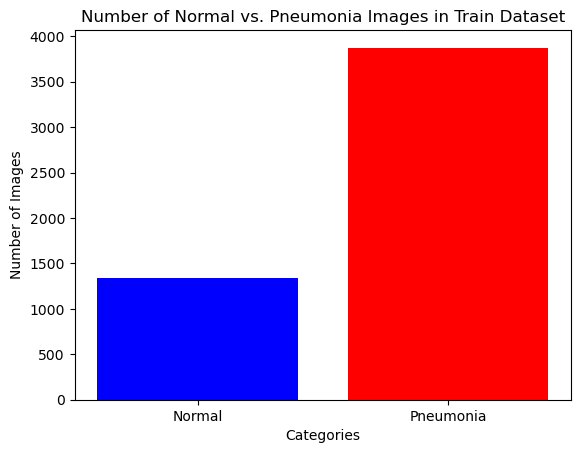

In [6]:
num_normal_images = len(normal)
num_pneumonia_images = len(pneumonia)

# Create a bar graph
categories = ['Normal', 'Pneumonia']
image_counts = [num_normal_images, num_pneumonia_images]

plt.bar(categories, image_counts, color=['blue', 'red'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Normal vs. Pneumonia Images in Train Dataset')
plt.show()

The data seems imbalanced . To increase the number of training examples, we will use data augmentation

### Previewing the images of both the classes

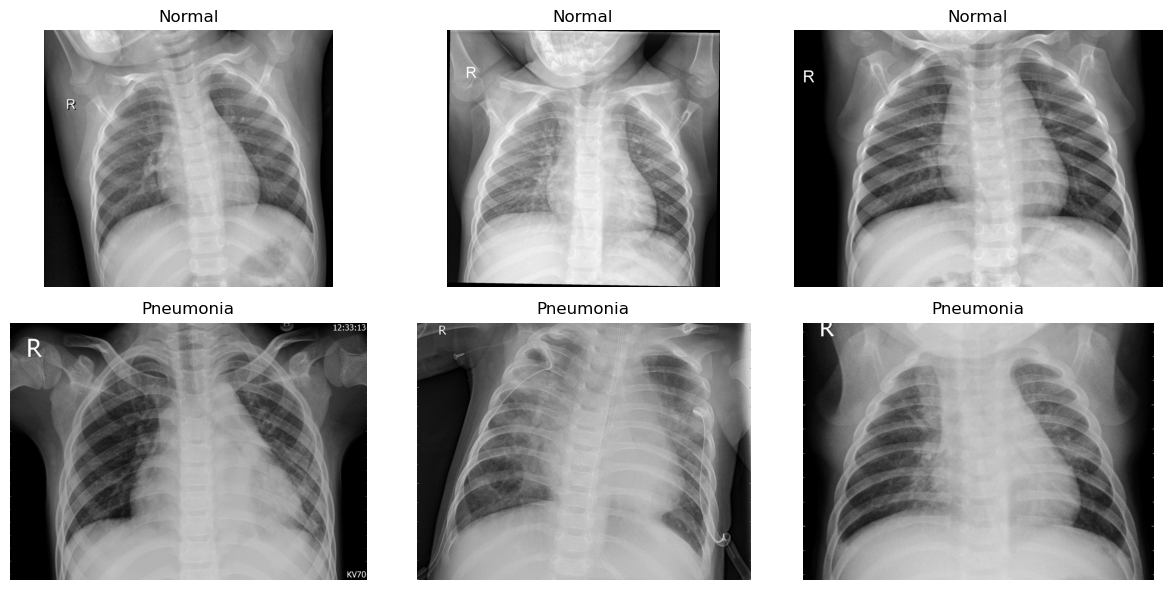

In [7]:
random_normal_images = random.sample(normal, 3)
random_pneumonia_images = random.sample(pneumonia, 3)

# Plot the randomly selected normal images
plt.figure(figsize=(12, 6))
for i, image_file in enumerate(random_normal_images):
    img = Image.open(os.path.join(train_dir, 'NORMAL', image_file))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')
    plt.axis('off')

# Plot the randomly selected pneumonia images
for i, image_file in enumerate(random_pneumonia_images):
    img = Image.open(os.path.join(train_dir, 'PNEUMONIA', image_file))
    plt.subplot(2, 3, i + 4)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    plt.axis('off')

plt.tight_layout()
plt.show()

Patients diagnosed with pneumonia typically display signs of lung congestion, often accompanied by the presence of pus or infectious substances within the pulmonary tissues. The images unveil conspicuous regions of opacity or consolidation within the lung tissue of the infected lungs. These areas of increased opacity and consolidation serve as critical markers for infection and inflammation within the lung parenchyma. They arise due to the accumulation of inflammatory cells, fluid, and debris within the alveoli, which are minuscule air sacs responsible for facilitating the exchange of oxygen and carbon dioxide in the lungs.

Applying PCA to see if there are distinct clusters form normal and pneumonia images

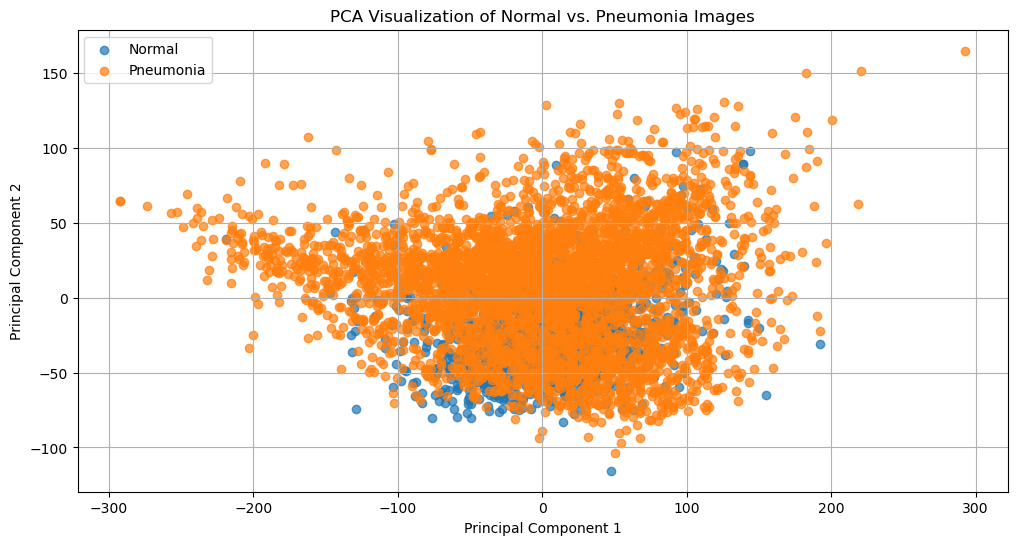

In [5]:
def load_and_preprocess_images(file_list, directory):
    images = []
    for file in file_list:
        img = Image.open(os.path.join(directory, file))
        img = img.convert("L")  # Convert to grayscale
        img = img.resize((128, 128))  # Resize for consistency (adjust dimensions as needed)
        img_array = np.array(img)
        images.append(img_array.flatten())  # Flatten the image into a 1D array
    return np.array(images)

# Load and preprocess normal and pneumonia images
normal_images = load_and_preprocess_images(normal, os.path.join(train_dir, 'NORMAL'))
pneumonia_images = load_and_preprocess_images(pneumonia, os.path.join(train_dir, 'PNEUMONIA'))

# Combine the two categories of images
all_images = np.concatenate((normal_images, pneumonia_images), axis=0)

# Standardize the image data
scaler = StandardScaler()
scaled_images = scaler.fit_transform(all_images)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Specify the number of components you want (2 for visualization)
pca_result = pca.fit_transform(scaled_images)

# Separate PCA results for normal and pneumonia images
pca_normal = pca_result[:len(normal_images)]
pca_pneumonia = pca_result[len(normal_images):]

# Plot PCA results
plt.figure(figsize=(12, 6))
plt.scatter(pca_normal[:, 0], pca_normal[:, 1], label='Normal', alpha=0.7)
plt.scatter(pca_pneumonia[:, 0], pca_pneumonia[:, 1], label='Pneumonia', alpha=0.7)
plt.title('PCA Visualization of Normal vs. Pneumonia Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

Normal lungs are more clustered than infected lungs.

### Data Modelling using dense layers and augmentation

In [8]:
# Define data augmentation parameters
batch_size = 32
image_size = (128, 128)
num_epochs = 15

# Create ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen = ImageDataGenerator(rescale=1.0 / 255.0)


# Create data generators for train, test and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Assumes binary classification (normal vs. pneumonia)
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Assumes binary classification (normal vs. pneumonia)
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Assumes binary classification (normal vs. pneumonia)
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [9]:
# Create and compile a simple dense layer model
model = Sequential()

# Add the input layer with the correct input shape
model.add(Flatten(input_shape=(128, 128, 3)))

# Add 4 dense layers with batch normalization and dropout

model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
# Add the output layer with sigmoid activation for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Creating a EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='min')

checkpoint_file = 'DENSE_model.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_file,
    monitor='val_loss',  
    save_best_only=True, 
    mode='min',  
    verbose=1  
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

2023-09-17 20:49:32.374884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
163/163 [==============================] - 45s 274ms/step - loss: 0.5969 - accuracy: 0.6931 - val_loss: 1.0809 - val_accuracy: 0.6250
Epoch 2/15
163/163 [==============================] - 44s 271ms/step - loss: 0.4778 - accuracy: 0.7893 - val_loss: 1.5040 - val_accuracy: 0.5625
Epoch 3/15
163/163 [==============================] - 46s 280ms/step - loss: 0.4420 - accuracy: 0.8023 - val_loss: 0.7458 - val_accuracy: 0.5625
Epoch 4/15
163/163 [==============================] - 45s 278ms/step - loss: 0.4142 - accuracy: 0.8242 - val_loss: 1.0278 - val_accuracy: 0.5625
Epoch 5/15
163/163 [==============================] - 44s 272ms/step - loss: 0.4113 - accuracy: 0.8246 - val_loss: 1.0282 - val_accuracy: 0.5625
Epoch 6/15
163/163 [==============================] - 45s 276ms/step - loss: 0.4072 - accuracy: 0.8219 - val_loss: 0.7630 - val_accuracy: 0.6250
Epoch 7/15
163/163 [==============================] - 44s 273ms/step - loss: 0.4143 - accuracy: 0.8242 - val_loss: 0.7074 - val_ac

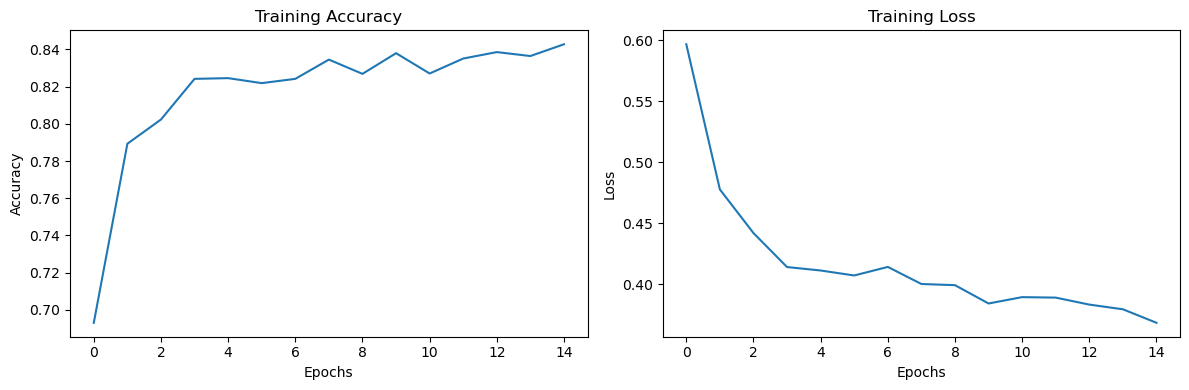

In [10]:
# Train the model using the data generator
history = model.fit(
    train_generator,
    epochs=num_epochs,
    callbacks=[early_stopping],
    validation_data=val_generator, 
    
)

# Plot training accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

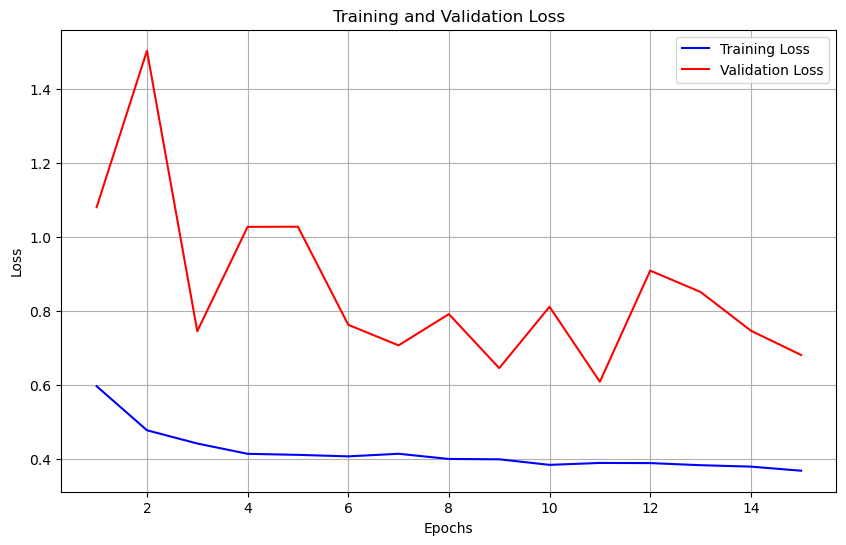

In [13]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Number of epochs
epochs = range(1, len(training_loss) + 1)

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Dense model evaluation

In [27]:
test_loss, test_accuracy = model.evaluate(test_generator)

# Print test loss and test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 [==============================] - 4s 182ms/step - loss: 0.4762 - accuracy: 0.7804
Test Loss: 0.4762
Test Accuracy: 78.04%


The dense model achieved a test accuracy of 78.04%, indicating that it can classify the test data with a reasonable level of accuracy. However, the test loss of 0.4762 suggests that there is still room for improvement, and further optimization or tuning of the model may be beneficial to reduce this loss and potentially increase accuracy. 

### CNN model

In [23]:
CNN_model = Sequential()

# Convolutional layers
CNN_model.add(Conv2D(128, (3, 3), strides=1, activation='relu', input_shape=(128, 128, 3), padding = 'same'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2, 2), strides=2))

CNN_model.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding = 'same'))
CNN_model.add(Dropout(0.1))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2, 2), strides=2))

CNN_model.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding = 'same'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2, 2), strides=2))

# Fully connected layers
CNN_model.add(Flatten())
CNN_model.add(Dense(units=128, activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
CNN_model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 64)      

In [24]:
CNN_filepath = "CNN_model.h5"

# Create a ModelCheckpoint callback to save the best model weights
CNN_model_checkpoint = ModelCheckpoint(
    CNN_filepath,
    monitor='val_loss',  
    save_best_only=True, 
    mode='min' 
)

Epoch 1/15
163/163 [==============================] - 90s 545ms/step - loss: 0.5877 - accuracy: 0.8102 - val_loss: 15.4343 - val_accuracy: 0.5000
Epoch 2/15
163/163 [==============================] - 98s 598ms/step - loss: 0.2980 - accuracy: 0.8769 - val_loss: 13.8463 - val_accuracy: 0.5000
Epoch 3/15
163/163 [==============================] - 94s 577ms/step - loss: 0.2802 - accuracy: 0.8863 - val_loss: 0.9974 - val_accuracy: 0.5000
Epoch 4/15
163/163 [==============================] - 94s 578ms/step - loss: 0.2569 - accuracy: 0.8992 - val_loss: 5.8439 - val_accuracy: 0.5000
Epoch 5/15
163/163 [==============================] - 94s 577ms/step - loss: 0.2416 - accuracy: 0.9064 - val_loss: 0.3432 - val_accuracy: 0.8750
Epoch 6/15
163/163 [==============================] - 95s 581ms/step - loss: 0.2234 - accuracy: 0.9162 - val_loss: 10.6669 - val_accuracy: 0.5000
Epoch 7/15
163/163 [==============================] - 97s 593ms/step - loss: 0.2186 - accuracy: 0.9164 - val_loss: 3.0644 - val

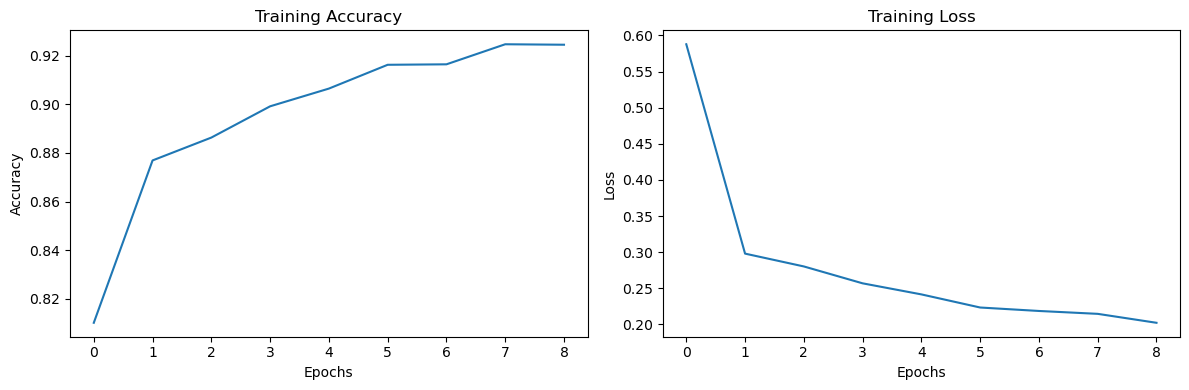

In [25]:
num_epochs = 15

# Fit the model to the training data
CNN_history = CNN_model.fit(
    train_generator,
    epochs=num_epochs,
    callbacks=[early_stopping, CNN_model_checkpoint],
    validation_data=val_generator,
    verbose=1
)

# Plot training accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(CNN_history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(CNN_history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

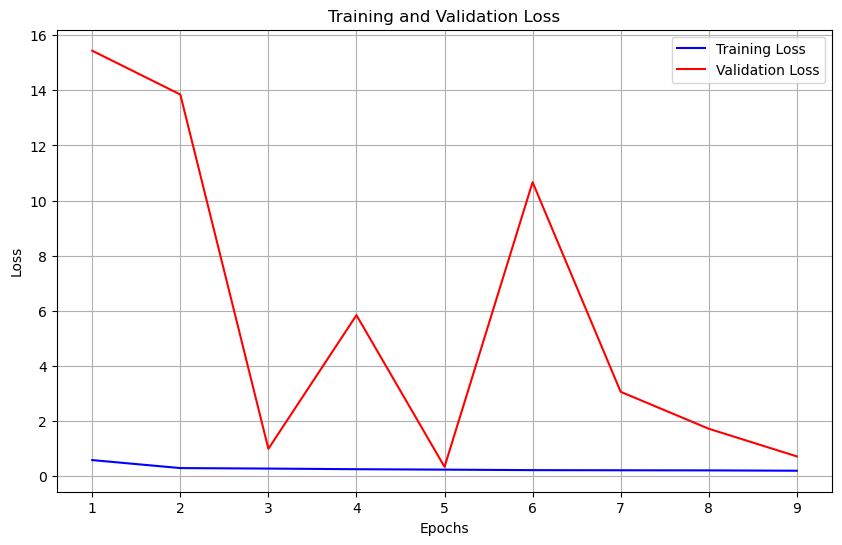

In [28]:
training_loss = CNN_history.history['loss']
validation_loss = CNN_history.history['val_loss']

# Number of epochs
epochs = range(1, len(training_loss) + 1)

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### CNN model evaluation

In [29]:
test_loss, test_accuracy = CNN_model.evaluate(test_generator)

# Print test loss and test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 [==============================] - 5s 224ms/step - loss: 0.3408 - accuracy: 0.8862
Test Loss: 0.3408
Test Accuracy: 88.62%


From the evaluation results for the CNN (Convolutional Neural Network) model are as follows:

> **Test Loss**: The test loss for the CNN model is 0.3408. This is significantly lower than the test loss of the dense model (0.4762). A lower test loss indicates that the CNN model's predictions are, on average, closer to the true labels in the test dataset. This suggests that the CNN model is better at capturing the underlying patterns and features in the data.

> **Test Accuracy**: The test accuracy for the CNN model is 88.62%. This accuracy is notably higher than that of the dense model (78.04%). The CNN model correctly classifies approximately 88.62% of the test samples, indicating a substantial improvement in performance over the dense model.

In comparison to the dense model, the CNN model demonstrates superior performance with both a lower test loss and higher test accuracy. Therefore, the CNN model is more effective at recognizing and classifying pneumonia status of an individual using X-ray images


20/20 [==============================] - 5s 220ms/step


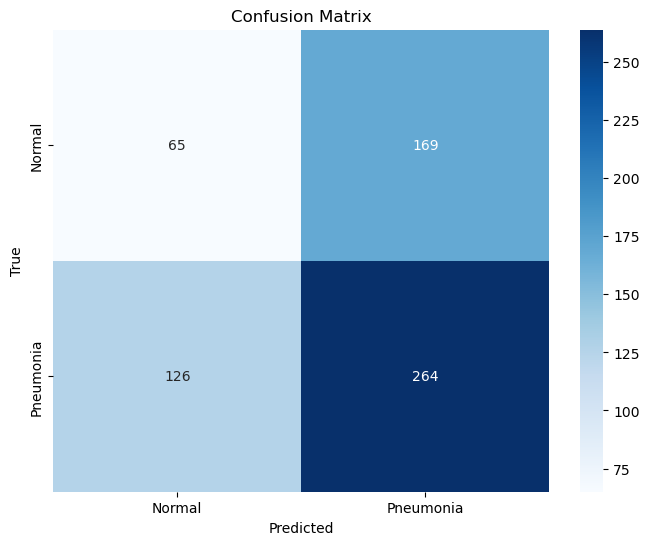

In [30]:
y_pred = CNN_model.predict(test_generator)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Get the true labels from the test data generator
y_true = test_generator.classes

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix with annotated values
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The displayed confusion matrix above provides insights into the classification results. It shows that 264 predictions successfully identified X-rays as pneumonia cases, constituting true positives. Moreover, 65 predictions correctly recognized X-rays as normal, adding to the true positives count. On the flip side, the matrix reveals that 169 predictions incorrectly labeled normal X-rays as pneumonia, leading to false positives. Additionally, 126 predictions were erroneously classified as normal, further contributing to the false positive count.

### Conclusion

The dense model achieved a test accuracy of 78.04% with a test loss of 0.4762, while the CNN model outperformed it significantly, attaining a higher test accuracy of 88.62% and a notably lower test loss of 0.3408. These results underscore the effectiveness of Convolutional Neural Networks (CNNs) in image classification tasks, as they are specifically designed to capture intricate spatial patterns and hierarchical features within images. Therefore, when dealing with image data as in our case, the CNN model is the preferred choice due to its superior performance in both accuracy and loss compared to the dense model. 

### Recommendation

In light of the business understanding and problem statement provided, we strongly recommend proceeding with the development and implementation of a deep learning model for pneumonia classification from chest X-ray images. This initiative aligns seamlessly with Safer Health Centre's mission to enhance patient care, diagnosis accuracy, and overall healthcare services. Here are key reasons to support this recommendation:

> **Improved Accuracy and Reliability**: By leveraging advanced technology, Safer Health Centre can develop a model that provides accurate and reliable pneumonia diagnoses. This ensures that patients receive timely and appropriate treatment, which is crucial for their well-being.

> **Scale Diagnostic Capabilities**: Implementing a deep learning model allows Safer Health Centre to scale its diagnostic capabilities. This is especially valuable during periods of high patient loads, where automation can alleviate the burden on medical professionals.

> **Integration with Existing Workflow**: The project's focus on seamless integration into the existing diagnostic workflow is commendable. This ensures that medical professionals can easily adopt the automated system as a supplementary tool, enhancing their diagnostic capabilities.

In conclusion, the development and implementation of a deep learning model for pneumonia classification from chest X-ray images represent a valuable opportunity for Safer Health Centre to enhance patient care, diagnosis accuracy, and overall healthcare services. This project embodies the organization's commitment to leveraging advanced technology to benefit both medical professionals and patients.